<a href="https://colab.research.google.com/github/ritiksp2411/ML-SMP-2019/blob/master/SE_ADAM_TEST1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7MB 2.8MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 163kB 12.7MB/s 
     |████████████████████████████████| 122kB 16.0MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=315c287e9ec8e5cda684a12cd98e66a3d20c03ef872a28e70a7d7fd2bd8dbfd5
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=1fee071aa5f104fe552422c16a1382d5dca2e71110ae5e1ff6b598bf534192f2
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=9dd594290a0b05e141c1ee0e9114aa99ed04d2ae905b32

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD,Adam
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_normal
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import cifar10
from keras.callbacks import  EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay

import wandb
from wandb.keras import WandbCallback
wandb.init(project="vgg-cifar10")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
batch_size = 128
epochs = 50
learning_rate = 0.035
lr_decay = 1e-7
lr_drop = 20
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train  /= 255
x_test /= 255

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
               
datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False,  
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False,  
            rotation_range=15,  
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            horizontal_flip=True, 
            vertical_flip=False)  
      
datagen.fit(x_train)


170500096/170498071 [==============================] - 11s 0us/step


In [4]:
BATCH_NORM = True
num_classes=10

def base_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv4' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv4' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv4' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(4096 ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, name='fc2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    # sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.75, nesterov=True)
    lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.8)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model


cnn_n = base_model()
cnn_n.summary()

cnn_n.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),callbacks=[WandbCallback(data_type="image", validation_data=(x_test, y_test), labels=class_names),
                               EarlyStopping(monitor='val_accuracy',patience=7, restore_best_weights=True)],verbose=2)
#cnn_n.save_weights('cifar10vgg.h5')




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0

313/313 - 7s
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[915  10  29   4   1   0   3   2  25  11]
 [  3 985   2   0   0   0   0   0   2   8]
 [ 14   2 901  14  13  20  25   8   3   0]
 [  8   3  71 725  25  80  66  13   4   5]
 [  4   1  48  16 868  10  25  27   1   0]
 [  1   3  37  89  19 824  15   9   0   3]
 [  4   2  25  11   1   1 955   0   0   1]
 [  8   1   8  15  14  20   6 924   1   3]
 [ 25  13   9   2   1   3   2   0 937   8]
 [  9  71   3   4   0   1   1   0   6 905]]


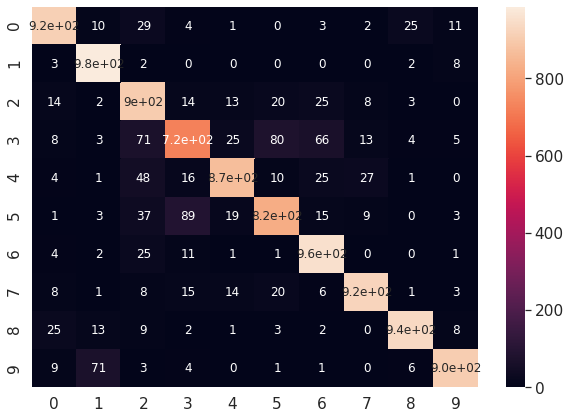

In [5]:


from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()